This iPython notebook documents the neural network based multiclass classification used for gridding categorical seafloor lithology data as described in 

Dutkiewicz, A., Müller, R.D., O’Callaghan, S. and Jónasson, H., 2015, Census of seafloor sediments in the world's ocean, Geology, 43, 795–798.

the paper is open-access and can be downloaded from here:

http://geology.gsapubs.org/content/43/9/795.long

and the SVM method is described in detail in the supplementary material for the paper:

ftp://rock.geosociety.org/pub/reposit/2015/2015271.pdf

Start with loading all the packages needed.

## Install requirments

To run this model locally, you will need the following additional packages:

* keras
* tensorflow

In [ ]:
!pip install tensorflow keras

In [2]:

%matplotlib inline  
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

Next we define a method that calibrates and trains a classifier called
SVM (Support Vector Machine) Classifier. This classifier can later be used to do prediction.

To do this, it needs to learn the relationship between the input and the output.
This is done as a supervised learning task, meaning that it looks at past observations of input-output pairs and
learns a pattern from it. Then, later, it can use the learned pattern to predict what the outputs would be for 
a set of new, query inputs.

Thus, it needs two things to learn the pattern:
* The observed locations for the input.
* The corresponding observed locations for the output (so that they are paired up properly)

This method gives us the trained SVM classifier that is able to do prediction

Later on, to do prediction, the SVM classifier will need:
* The query locations for the input (which is where we want to know what the corresponding outputs are. So that it can output
* The predicted outputs at those query locations

The calibration here is done using a cross-validation approach.
This means we split the available data into multiple groups.

Some groups are withheld from the model, whereas the others remain available to the model.
Validation means that the model learn patterns from the remaining available data and tests its 
predictive power on the withheld data it was not allowed to see. It then records how well it does
as a performance score.

Cross-validation means that it switches which groups are withheld and which groups are not,
and averages all these performance scores together.


In [3]:
def svm_cross_val(observed_inputs, observed_outputs):

    # Define a grid of kernel parameters to search from
    C_range = 10.0 ** np.linspace(-2, 3, 8)
    gamma_range = 10 ** np.linspace(-2, 1, 6)
    param_grid = dict(gamma=gamma_range, C=C_range)

    # Set up cross-validation folds and train SVM
    cv = StratifiedKFold(y=observed_outputs, n_folds=5)
    grid = GridSearchCV(SVC(kernel='rbf', probability=True, class_weight={6: 10, 7: 10}), 
                        param_grid=param_grid, cv=cv, verbose=3, n_jobs=5)
    grid.fit(observed_inputs, observed_outputs)
    svc = grid.best_estimator_
    return svc

Load the data. Make sure you put the data file in the same folder as this ipython notebook!
If is the file name is incorrect here, change it appropriately.

In [4]:
file_name = 'data/seafloor_data.npz'
print('Loading data...')
data = np.load(file_name)
print('Data loaded.')

Loading data...
Data loaded.


Here we obtain the observed latitude, longitude locations. These are our observed inputs.
We also obtain the observed labels. These are our observed outputs.

In [5]:
lat = data['lat']
lon = data['lon']
labels = data['labels'].ravel().astype(int)

## Join GeoChemical Data

In [6]:
dfdata = pd.read_csv("data/train_clean.csv")

litho_df = pd.DataFrame({'lon': data['lon'].flatten(),
                         'lat': data['lat'].flatten(),
                         'label': data['labels'].flatten()})
litho_df = litho_df.round(0).astype(int)

dfdata = pd.merge(dfdata, litho_df, left_on=['longitude', 'latitude'], right_on=['lon', 'lat'], how='inner')

print(f"Merging with Geochemical data gives {len(dfdata)} data points")
dfdata.head()

Merging with Geochemical data gives 13945 data points


,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature,lon,lat,label
0,-19,75,4,-167.0,NaN,8.025972,NaN,727.085754,30.408110,NaN,-1.930649,-19,75,4
1,-19,75,4,-167.0,NaN,8.025972,NaN,727.085754,30.408110,NaN,-1.930649,-19,75,12
2,-19,75,4,-167.0,NaN,8.025972,NaN,727.085754,30.408110,NaN,-1.930649,-19,75,12
3,-18,75,4,-115.0,7.739881,7.905418,0.689741,646.117432,31.694929,4.473612,-2.038240,-18,75,4
4,-18,75,4,-115.0,7.739881,7.905418,0.689741,646.117432,31.694929,4.473612,-2.038240,-18,75,4


## Merge 13 Lithology Types into 5 Classes

**Class 1**

1          128/130/132               ;Gravel and coarser
2          255/241/0                   ;Sand
3          250/169/25                 ;Silt

**Class 2**

4          112/75/42                   ;Clay

**Class 3**

5          14/145/207                 ;Calcareous ooze
13        0/46/167                     ;Fine-grained calcareous sediment

**Class 4**

6          13/150/71                   ;Radiolarian ooze

**Class 5**

7          190/215/83                 ;Diatom ooze

**Excluded:**

8          85/147/141                 ;Sponge spicules
9          131/112/178               ;Mixed calcareous/siliceous ooze
10        247/187/213               ;Shells and coral fragments
11        234/27/27                   ;Ash and volcanic sand/gravel
12        195/154/107               ;Siliceous mud

In [7]:
merge_mapping = {
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 3,
    13:3,
    6: 4,
    7: 5
}

n_before = len(dfdata)
dfdata = dfdata[dfdata['lithology'].isin([1,2,3,4,5,13,6,7])]
n_after = len(dfdata)
print(f"After excluding 8-12 we lost {n_before - n_after} data points")

dfdata['lithology'] = [merge_mapping.get(x, x) for x in dfdata['lithology']]
dfdata['lithology'].unique()

After excluding 8-12 we lost 1425 data points


array([2, 1, 3, 5, 4])

## Train with Neural Network Model


In [8]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight


### **1. Preprocessing:**
* Fill NaN with feature mean
* Standardise features
* Onehot encode target - lithology



In [9]:
from IPython.display import display
training_data = dfdata.copy()

to_remove = ['longitude', 'latitude', 'lithology', 'label', 'lon', 'lat']

features = []
for name in training_data:
    if name not in to_remove:
        features.append(name)
        
# obtain list of feature names
target = "lithology"

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# fix random seed for reproducibility
seed = 0
np.random.seed(seed)
X = training_data[features].astype(float)
Y = training_data[target]
print(f"Training data: number of data points={len(X)}")
display(X.head())

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

Training data: number of data points=12520


,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-167.0,5.672544,8.025972,0.542324,727.085754,30.408110,8.542307,-1.930649
1,-167.0,5.672544,8.025972,0.542324,727.085754,30.408110,8.542307,-1.930649
2,-167.0,5.672544,8.025972,0.542324,727.085754,30.408110,8.542307,-1.930649
3,-115.0,7.739881,7.905418,0.689741,646.117432,31.694929,4.473612,-2.038240
4,-115.0,7.739881,7.905418,0.689741,646.117432,31.694929,4.473612,-2.038240



### **2.Cross Validation Training**
We will deploy keras - a neural network library which is capable for running on top of Tensorflow.
The neural network has the following structure:

- Input layer
- Hidden layer 1: consists of 128 nerons
- Hidden layer 2: consists of 64 nerons
- Hidden layer 3: consists of 32 nerons
- Output layer

In [10]:
def baseline_model():
    activation = "relu"
    dropout_ratio = 0.1
    initializer = "random_uniform"
    numclass = dummy_Y.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation=activation, kernel_initializer=initializer))
    model.add(Dense(64, activation=activation, kernel_initializer=initializer))
    model.add(Dense(32, activation=activation, kernel_initializer=initializer))
    model.add(Dense(numclass, activation="softmax", kernel_initializer=initializer))
    # compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# class reweighting for imbalanced class
weight = {i: x for i, x in enumerate(class_weight.compute_class_weight('balanced', np.unique(Y), Y))}
print(weight)
print(X.shape)
print(Y.shape)

{0: 2.1006711409395975, 1: 0.6123746637319638, 2: 0.4420123565754634, 3: 13.834254143646408, 4: 1.797559224694903}
(12520, 8)
(12520,)


/Users/wan220/.virtualenvs/sea2/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[1 1 1 ... 4 4 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [12]:
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)

train_indice, test_indice = [], []
for train, test in kfold.split(X):
    train_indice.append(train)
    test_indice.append(test)
    
result = np.zeros((len(Y), len(np.unique(Y))))

print(baseline_model().summary())

estimators = []
histories = []
for train_ind, test_ind in kfold.split(X):
    Xtrain = X[train_ind]
    Ytrain = dummy_Y[train_ind]
    Xtest = X[test_ind]
    # train
    estimator = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=10, verbose=False)
    history = estimator.fit(X[train_ind], dummy_Y[train_ind], class_weight=weight)
    # predict
    prediction = estimator.predict_proba(X[test_ind])
    print(f"Training: Accuracy={accuracy_score(Y[train_ind], estimator.predict(X[train_ind]))}")
    print(f"Testing : Accuracy={accuracy_score(Y[test_ind], estimator.predict(X[test_ind]))}")
    result[test_ind, :] = prediction
    estimators.append(estimator)
    histories.append(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 165       
Total params: 11,653
Trainable params: 11,653
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Please use `model.predict()` instead.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer 

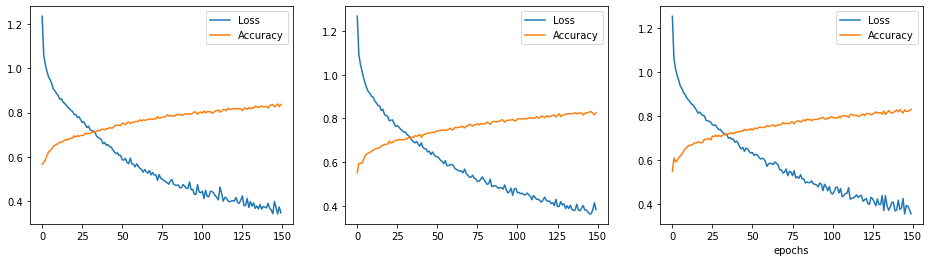

In [13]:
pl.subplots(1, 3, figsize=(16, 4))
for i, history in enumerate(histories):
    pl.subplot(1, 3, i + 1)
    epoches = range(len(history.history['loss']))
    pl.plot(epoches, history.history['loss'], '-', label="Loss")
    pl.plot(epoches, history.history['accuracy'], '-', label="Accuracy")
    pl.legend()
pl.xlabel("epochs")
pl.show()

## Evaluate Result

Evaluaton on Testing data for 3 cross validation, Average Accuracy = 0.791373801916933


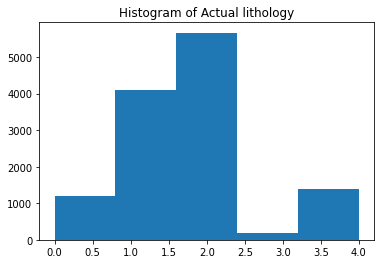

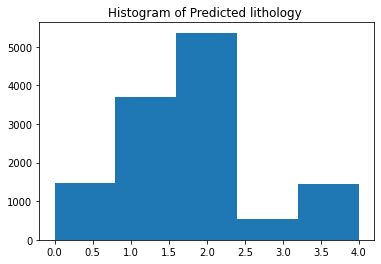

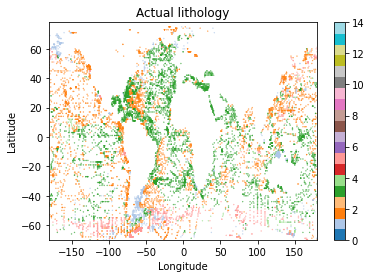

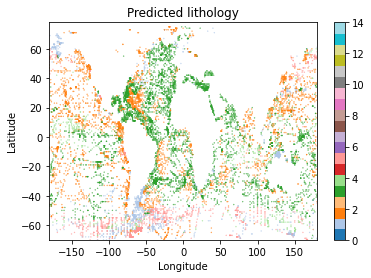

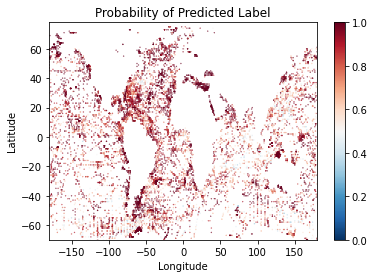

In [14]:
def draw_hist(y, title):
    # plot the histogram of lithology
    pl.hist(y, bins=5)
    pl.title(title)
    pl.show()
    
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = pl.scatter(lon, lat, s=0.1, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
    
result_discrete = result.argmax(axis=1)
prob = np.max(result, axis=1)

lon = dfdata['longitude'].values
lat = dfdata['latitude'].values
y = dfdata['lithology'].values

print("Evaluaton on Testing data for 3 cross validation, Average Accuracy = {}".format(accuracy_score(Y, result_discrete)))
draw_hist(Y, "Histogram of Actual lithology")
draw_hist(result_discrete, "Histogram of Predicted lithology ")
draw_global(lon, lat, y, "Actual lithology")
draw_global(lon, lat, result_discrete + 1, "Predicted lithology")
draw_global(lon, lat, prob, "Probability of Predicted Label", cmap='RdBu_r', vmin=0, vmax=1)

In [15]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=10, verbose=False)
estimator.fit(X, dummy_Y, class_weight=weight)

In [16]:
prediction = estimator.predict_proba(X).argmax(axis=1)
print(f"Accuracy on Training All Data Points={accuracy_score(Y, prediction)}")

Accuracy on Training All Data Points=0.8332268370607029


## Predict for All Data Points

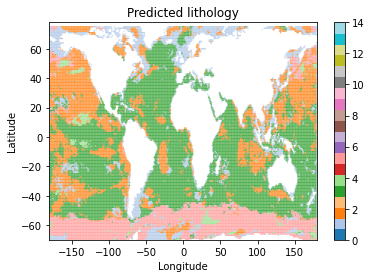

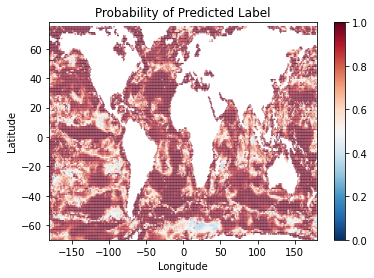

In [17]:
query_data = pd.read_csv("data/train_clean.csv")

# obtain list of feature names
target = "lithology"
features = list(query_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

Xq = query_data[features].astype(float)
Xq = scaler.fit_transform(Xq)

prediction = estimator.predict_proba(Xq)
q_discrete = prediction.argmax(axis=1)
q_prob = prediction[:, q_discrete]

draw_global(query_data['longitude'], query_data['latitude'], q_discrete + 1, "Predicted lithology")
q_prob = np.max(prediction, axis=1)
draw_global(query_data['longitude'], query_data['latitude'], q_prob, "Probability of Predicted Label", cmap='RdBu_r', vmin=0, vmax=1)

## Create BaseMap

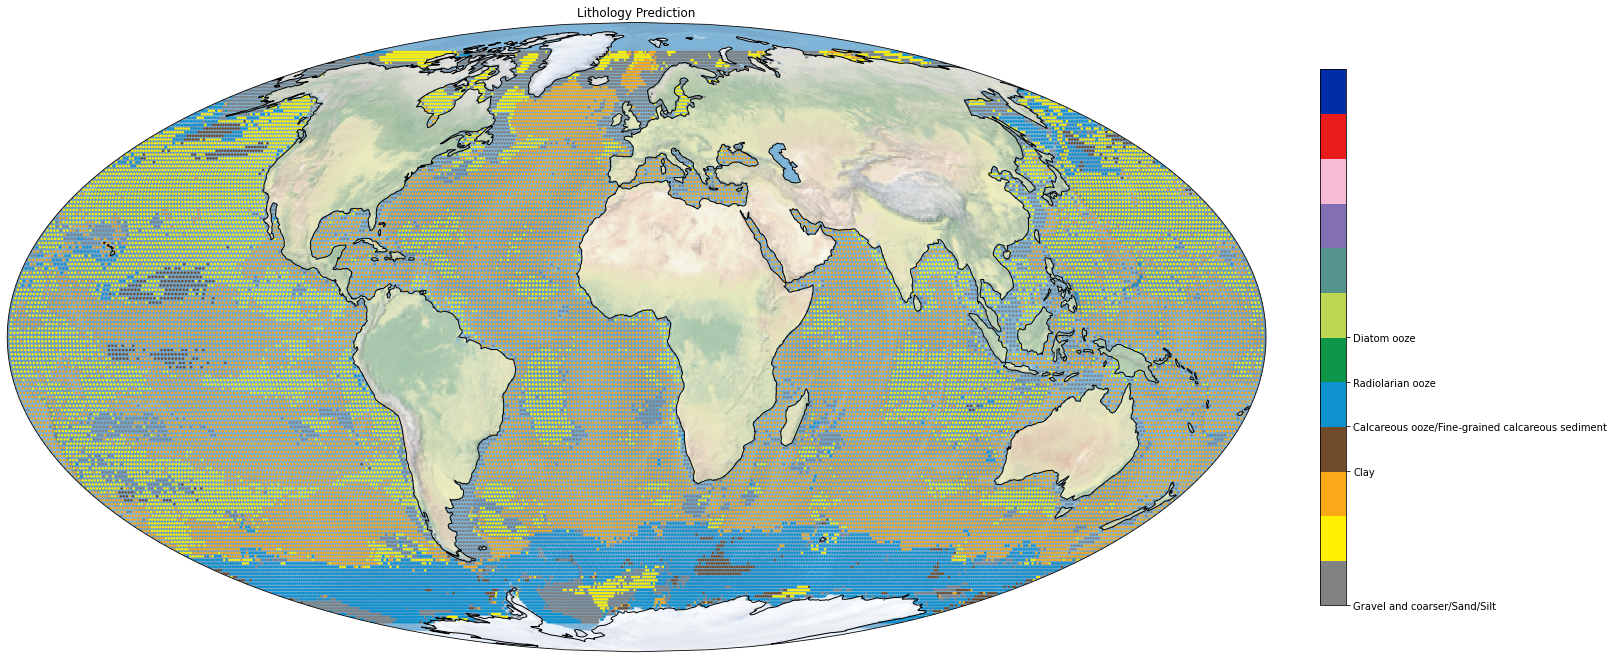

In [22]:
import cartopy.crs as ccrs
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

rgbs = np.array([
    [128, 130, 132],
    [255, 241, 0],
    [250, 169, 25],
    [112, 75, 42],
    [14, 145, 207],
    [13, 150, 71],
    [190, 215, 83],
    [85, 147, 141],
    [131, 112, 178],
    [247, 187, 213],
    [234, 27, 27],
    [195, 154, 107],
    [0, 46, 167]
]) / 255

# lithology_mapping = {
#     1: "Gravel and coarser",
#     2: "Sand",
#     3: "Silt",
#     4: "Clay",
#     5: "Calcareous ooze",
#     6: "Radiolarian ooze",
#     7: "Diatom ooze",
#     8: "Sponge spicules",
#     9: "Mixed calcareous/siliceous ooze",
#     10: "Shells and coral fragments",
#     11: "Ash and volcanic sand/gravel",
#     12: "Siliceous mud",
#     13: "Fine-grained calcareous sediment"
# }

lithology_mapping = {
    1: "Gravel and coarser/Sand/Silt",
#     2: "Sand",
#     3: "Silt",
    4: "Clay",
    5: "Calcareous ooze/Fine-grained calcareous sediment",
    6: "Radiolarian ooze",
    7: "Diatom ooze",
#     8: "Sponge spicules",
#     9: "Mixed calcareous/siliceous ooze",
#     10: "Shells and coral fragments",
#     11: "Ash and volcanic sand/gravel",
#     12: "Siliceous mud",
#     13: "Fine-grained calcareous sediment"
}

cmap = mpl.colors.ListedColormap(rgbs)
boundaries = list(range(1, 14))
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)


q_lon = query_data['longitude']
q_lat = query_data['latitude']

pl.figure(figsize=(24, 20))
ax = pl.axes(projection=ccrs.Mollweide())
ax.stock_img()
ax.coastlines()
ax.scatter(q_lon, q_lat, c=q_discrete + 1,
           cmap=cmap, s=2, norm=norm, transform=ccrs.PlateCarree())
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = pl.colorbar(sm, ax=ax, ticks=list(lithology_mapping.keys()), fraction=0.02, pad=0.04)
cb.ax.set_yticklabels(list(lithology_mapping.values()))
# cb.ax.set_xlabel("Probability of Predicted Label")
ax.set_title("Lithology Prediction")
# pl.savefig("Lithology_Prediction.png")
pl.show()

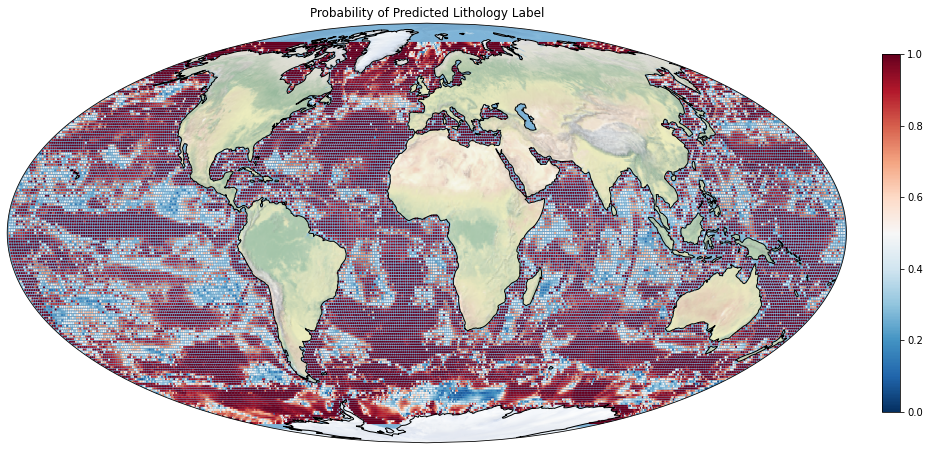

In [23]:
pl.figure(figsize=(16, 12))
ax = pl.axes(projection=ccrs.Mollweide())
ax.stock_img()
ax.coastlines()
ax.scatter(q_lon, q_lat, c=q_prob,
           cmap='RdBu_r', s=1, transform=ccrs.PlateCarree())
# ax.colorbar()
sm = pl.cm.ScalarMappable(cmap='RdBu_r', norm=pl.Normalize(0,1))
sm._A = []
cb = pl.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
ax.set_title("Probability of Predicted Lithology Label")
pl.savefig("Lithology_Prediction_Probability.png")
pl.show()

Next we pad the observed data on both sides of the map.

Instead of having the map going from -180 degrees longitude to 180 degrees longitude,
we will add another 10 degrees of longitude on both sides so that the map goes from -190 degrees longitude
to 190 degrees longitude.

This allows the SVM to actually make use of the observations that are on the edges of the map properly.
For example, an observation at 179 degrees longitude is actually very close to -179 degrees longitude, but because
those numbers (-179 and 179) are very far, the model will not know that. Instead, we copy both sides of the map and
paste it on the other sides of the map to extend the map, so that the observations at -179 degrees longitude will
also be registered as an observation at 181 degrees longitude, so that the model now knows that it is close to an 
observation at 179 degrees longitude, for example.

In [ ]:
def pad_map(lon, lat, labels):
    
    east_strip_indices = (lon >  170) * (lon <  180)
    west_strip_indices = (lon < -170) * (lon > -180)

    lon_east_pad = lon[west_strip_indices] + 360
    lat_east_pad = lat[west_strip_indices]
    label_east_pad = labels[west_strip_indices[:, 0]]

    lon_west_pad = lon[east_strip_indices] - 360
    lat_west_pad = lat[east_strip_indices]
    label_west_pad = labels[east_strip_indices[:, 0]]

    lon_pad = np.append(lon_west_pad, np.append(lon, lon_east_pad))
    lat_pad = np.append(lat_west_pad, np.append(lat, lat_east_pad))
    labels_pad = np.append(label_west_pad, np.append(labels, label_east_pad))
    
    return lon_pad, lat_pad, labels_pad

lon, lat, labels = pad_map(lon, lat, labels)

Here we collected our observed data.

In [ ]:
x = np.array([lon, lat]).T
y = labels

Here we generate the query locations - locations we want to predict what the output labels would be like.
Since we want to generate a map, we will basically query everywhere on the map, from -180 degrees longitude
to 180 degrees longitude, and from -90 degrees latitude to 90 degrees latitude. These query points will form a grid
that is 1 degree apart from each other in both directions.

In [ ]:
# min_lons = -180
# max_lons = 180
# min_lats = -90
# max_lats = 90
# query_lons = np.linspace(min_lons, max_lons, 361)
# query_lats = np.linspace(min_lats, max_lats, 181)
# xeva, yeva = np.meshgrid(query_lons, query_lats)
# xs = np.c_[xeva.ravel(), yeva.ravel()]

Here we visualise the locations we actually have observed data for. These are the data we use to learn a pattern
for classification.

In [ ]:
# pl.plot(x[:,0], x[:,1], '.')
# pl.show()

To Calibrate or Not To Calibrate:
Given the description above, decide if you want to calibrate the SVM classifier with cross-validation or not.
If not, then we will just use the pre-learnt configuration for the SVM classifier from the paper.
Note that calibration will take a long time! (Probably several hours)
Set the variable below to True or False appropriately.

In [ ]:
to_calibrate = False

Here we use our SVM Classifier to learn patterns from the data, and then to predict the output labels for new
query input locations.

If you chose to have it calibrated, that means the SVM classifier has optimised a number of global parameters using a cross-validation approach. This will take a very long time.
Otherwise, we will just use the calibration from the paper.

In [ ]:
# if to_calibrate:
#     print('Calibrating SVM Classifier parameters with cross-validation... This could take several hours.')
#     classifier = svm_cross_val(x, y)
# else:
#     print('Training SVM Classifier without cross-validation... This will take a few minutes.')
#     classifier = SVC(kernel='rbf', probability=True, C=1000, gamma=0.01, class_weight={6: 10, 7: 10})
#     classifier.fit(x, y)
    
# ys = classifier.predict(xs)

In [ ]:
# from sklearn.metrics import accuracy_score
# # accuracy_score(y, ys)
# ypred = classifier.predict(x)
# accuracy_score(y, ypred)

In [ ]:
# np.unique(y)
# x.shape

Visualise the prediction result from the SVM classifier with no training.

In [ ]:
# pl.figure(figsize=(15,15))
# prediction_mesh = np.reshape(ys, xeva.shape)
# pl.imshow(prediction_mesh[30:150,:], origin='lower')